In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import os

# Import packages, establish starting global varibles and load the data
- We can quickly see the dimensions of the dataframe along with the fact that ther are no null values.  
- It is worth noting, in many real-world scenarios this is HIGHLY uncommon. 

In [2]:
####################
# GLOBAL VARIABLES #
####################
dta_pth = '../data/'
fn = 'news.csv'
f_pth = os.path.join(dta_pth,fn)
y_map = {'FAKE':0,'REAL':1}
y_col = 'label'
random_state = 42

df = pd.read_csv(f_pth)
print('File "{}": {} rows x {} columns\n'.format(fn,df.shape[0],df.shape[1]))
df.info()

File "news.csv": 6335 rows x 4 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [3]:
X = df.drop(y_col,axis=1)
y = df[[y_col]]
# encode y feature as Fake = 0, Real = 1
y['Target'] = y[y_col].map(y_map)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Quickly inspect the first and last N rows to get a very high level of the data contents
- The Title and Text fields represent the title of the article, while the text column contains the content for each article.
- The unnamed column is a unique ID for each article in the dataset

In [4]:
df.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [5]:
df.tail(10)

,Unnamed: 0,title,text,label
6325,8411,Will the Media Reset After the Election or Are...,Written by Peter Van Buren venerable New Yor...,FAKE
6326,6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,FAKE
6327,3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,REAL
6328,9337,Radio Derb Is On The Air–Leonardo And Brazil’s...,,FAKE
6329,8737,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,FAKE
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL


** Since unique id for each record, with all REAL rows assigned id values less than 5276 and all FAKE rows assigned values above 5276.  Of course, this data does not pertain in any way to the problem and needs to be removed from the analysis.**

In [6]:
df.sort_values([df.columns[0]])

,Unnamed: 0,title,text,label
5603,2,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,REAL
565,3,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",REAL
2099,5,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,REAL
2197,6,"Despite Constant Debate, Americans' Abortion O...",It's been a big week for abortion news.\n\nCar...,REAL
5974,7,Obama Argues Against Goverment Shutdown Over P...,President Barack Obama said Saturday night tha...,REAL
...,...,...,...,...
1213,10549,French Political Leader: “France is about to E...,"Posted on October 31, 2016 by Theodore Shoebat...",FAKE
4863,10551,Man with unfashionable front door feared by ne...,Man with unfashionable front door feared by ne...,FAKE
5397,10553,Obamacare Architect on Rising Premiums: It’s N...,"Washington Free Beacon October 26, 2016 \nDr. ...",FAKE
208,10555,Clinton Vs. Trump: Latest Electoral Prediction...,(Before It's News)\nIt is fun to look at polls...,FAKE


In [7]:
cols = df.columns.tolist()
cols[0] = 'id'
df.columns = cols
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### While the dataframe does not have any Null values, with text data it is a good idea to check at a high level and see if any the contents of the Text and Title column carry emptry strings.
- The Title field only appears to contain one row with a 'missing' title as shown by the single row with a string length of 1.  The next shortest is a single 5

In [8]:
df['title'].apply(lambda x: len(x)).value_counts().sort_index()

1      1
5      1
8      2
9      4
10     2
      ..
221    1
229    2
231    1
269    1
289    1
Name: title, Length: 168, dtype: int64

In [9]:
df.loc[df['title'].apply(lambda x: len(x) == 1),'title']

3456    :
Name: title, dtype: object

In [10]:
df.loc[df['title'].apply(lambda x: len(x) == 5),'title']

2417    White
Name: title, dtype: object

### There are a few dozen rows in the Text column which  appear to contain only empty string values.  
- The next shortest length, as 12 characters long.

In [11]:
# It appears that 36 of the artilces do not have any text as shown by this value count on string length
df['text'].apply(lambda x: len(x)).value_counts().sort_index()

1         36
12         1
13         1
17         1
34         1
          ..
56795      1
68208      1
92561      1
99355      1
115372     1
Name: text, Length: 4562, dtype: int64

### Inspecting these that rows only have empty strings for the text contents, we see that they are all FAKE articles.  There are a few options for handling this missing data.  
1. Leave the missing information as is
2. Impute the TITLE values for the text values.
3. Remove these rows from the data set.

At this point, it is too early to say which is the 'best' option.  The best answer depends on a few things: 
    <li> **a)** which scenario will most represent the real-world, out of sample articles the model will be classifying and </li>
    <li> **b)** which column features we end up using to build our final model </li> <br>
    Given this situation, I will use the second option and impute the missing text data with the title data

In [12]:
df.loc[df['text'].apply(lambda x: len(x) == 1), :]

,id,title,text,label
106,5530,The Arcturian Group by Marilyn Raffaele Octobe...,,FAKE
710,8332,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,FAKE
806,9314,Southern Poverty Law Center Targets Anti-Jihad...,,FAKE
919,10304,Refugee Resettlement Watch: Swept Away In Nort...,,FAKE
940,9474,Michael Bloomberg Names Technological Unemploy...,,FAKE
1664,5802,Alert News : Putins Army Is Coming For World W...,,FAKE
1736,9564,An LDS Reader Takes A Look At Trump Accuser Je...,,FAKE
1851,5752,America’s Senator Jeff Sessions Warns of Worse...,,FAKE
1883,8816,Paris Migrant Campers Increase after Calais Is...,,FAKE
1941,7525,Putins Army is coming for World war 3 against ...,,FAKE


In [13]:
df.loc[df['text'].apply(lambda x: len(x) == 1), 'text'] = df.loc[df['text'].apply(lambda x: len(x) == 1), 'title']

## Take a look at the data by Target type: FAKE vs REAL
- Investigate y labels and any potential imbalance.
- Value counts quickly shows the two categories are almost perfectly balanced.  

In [18]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

## Review a random sample of the title column data 
- Explore for differences and see if we can get any intuition about the data abd what might differentiate  between REAL and FAKE article titles

In [14]:
# Function to pivot y-label category entries: in this case for REAL and FAKE
def juxtapose_categories(df,idx,cat_col,val_col):
    options = df[cat_col].unique()
    df_juxtapose = pd.DataFrame()
    for opt in options:
        t_df = df.pivot(index=idx,columns=cat_col,values=val_col)[[opt]].dropna().reset_index(drop=True)
        df_juxtapose = pd.concat([df_juxtapose,t_df],axis=1)
    return df_juxtapose

In [15]:
# Set display width so that entire text for each label is visible
pd.set_option('display.max_colwidth', -1) 
sample_size = 10
juxtapose_categories(df,'id',y_col,'title').sample(sample_size,random_state=7)

label,FAKE,REAL
2325,Comment on Sweden on the brink? Police force pushed to breaking point by violence amid migrant influx by Paul Blake,Angela Merkel to Visit White House on Feb. 9
3031,Putin: Russia Is Not Going To Attack Anyone,Historic firsts fill evening at Democratic National Convention
638,Arkansas Republicans Put The Word “Liar” In Hillary’s Name On Ballot,Bernie Sanders' big day
2039,World wildlife ‘falls by 58% in 40 years’,Scalia lies in repose at Supreme Court
1490,Trump: A people’s ‘new world order’ taking shape?,Seeking Refuge: Five lessons from Europe's migration crisis
2899,"PIERS MORGAN: “Get Off Your High Horse, Hillary. Only ONE Candidate is Up To Her Neck in FBI Probes and Her Name Isn’t Donald” – TruthFeed","Trump doctor’s letter: He takes cholesterol drug, is overweight but is in ‘excellent’ health"
1262,President Trump! A nightmare of the Ukrainian politicians! (English subs),How America is quietly becoming a climate change leader
1232,Is Trump winning? The future of America depends on a few states,DR. MANNY: Water crisis in Flint is just the tip of the iceberg
1364,Dr. Duke and Dr. MacDonald Call for Prosecution of Hillary for Treasonous Support of ISIS.,Meet The Couples Fighting To Make Marriage Equality The Law Of The Land
1271,The Loosening Grip,Earth had warmest winter on record


# Now, let's take a look at a few random samples of the Text contents too
- Since these are much larger, I'll only grab a row at a time and check 10 of these.
- Looking at this small handful, it is hard to get develop any intuitive insight like we did with the Title column. 

In [17]:
# adjust column width so that entire text contents for a single row are visible.
pd.set_option('display.max_colwidth', -1)
sample_size = 1
juxtapose_categories(df,'id',y_col,'text').sample(sample_size,random_state=7)

label,FAKE,REAL
2325,"DCG | 5 Comments \nAin’t multiculturalism grand? \nFrom Daily Express : The Scandinavian country is facing an existential crisis with on average three police officers handing in their resignations a day. If the alarming trend continues, and police officers continue to resign more than 1,000 officers will have quit the service by New Years. \nSince the migrant crisis began last summer, Sweden has been hit by a series of brutal crimes and violent incidents . In 2015 alone Sweden, with a population of 9.5million, received over 160,000 asylum applications and the country is expected to take as many as 190,000 refugees, or two per cent of the population, by the end of 2016. \nSince the Second World War Sweden has prided itself on helping migrants who cross their borders despite some moves to the political right in recent years. \nBut police have now admitted the force has reached breaching point as more than 50 areas in the country have now been placed on a “no-go zone” list . \nIn February a report from Sweden’s National Criminal Investigation Service announced there were 52 areas where officers would not cope with the levels of crime being committed . Sex assaults , drug dealing and children carrying weapons were just some of the incidents mentioned in the report. In September, Swedish officials were forced to add another three areas to the list. \nNow the Police Association have said they need at least 200 new officers to regain control in the south-east of the country. \nThomas Stjernfeldt, from the region’s police association, told SVT : “We are missing extremely many officers in the operational sector, right now we need 200 more officers to be added to the force to establish a reasonable working environment in the southeast of Götaland .” Götaland is one of the regions in the country that has been hit hard by the car fire attacks, which have been occurring throughout Sweden. \nOn Monday, Express.co.uk reported a number of the arsonist attacks in the city of Växjö, in Götaland, had been committed by frustrated migrants . Currently there are more than 6,000 suspected crimes that are unsolved in the area and 400 of these cases are suspected to be rapes, murder or attempted murder. \nMr. Stjernfeldt said the figures are alarming and police officers are constantly forced to work overtime in an attempt to solve the reported crimes. \nThe Police Association admitted it fears the public will lose faith in the force and their ability to protect citizens if the situation is not resolved. \nThe union’s call for more resources echoes National Police Commissioner Dan Eliasson’s February warning, where he said he needed a further 4,100 officers and specialist staff to reestablish law and order in Sweden. \nDCG","President Barack Obama will play host to German Chancellor Angela Merkel in Washington, D.C. next week, the White House announced Monday.\n\nMs. Merkel will visit the White House on Feb. 9, where she and the president are expected to discuss issues like Russia, Ukraine, counterterrorism and the challenges in the broader Middle East. The two leaders will have an Oval Office meeting followed by a working lunch."


In [18]:
# reset the display to default setting so that row contents of dataframe are truncated
pd.reset_option('display')

### Iterating through a few random samples of FAKE vs REAL records, one potential trend emerges: FAKE entries tend to have a higher number of UPPERCASE words in the Title (and potentially in the text as well).
- Given this, it might be worth while to count of the number of uppercase words in the title could be one potential feature for use in a model later, so let's grab create a column with that information

In [19]:
# Split the title string into a list and count the the number of upper case words in each
df['TITLE_UPPER_CNT'] = df['title'].apply(lambda row: sum([1 for word in row.split() if word.isupper()]))
df['TEXT_UPPER_CNT'] = df['text'].apply(lambda row: sum([1 for word in row.split() if word.isupper()]))

In [20]:
df.head()

,id,title,text,label,TITLE_UPPER_CNT,TEXT_UPPER_CNT
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,38
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2,3
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,0,6
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,1,5
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,0,3


### Count of uppercase words distribution.
- Looking at the quartile breakdown of the Distribution of count of uppercase words in the the Title column, we see  there could be a divergence starting somewhere in the 3rd or 4th quartile, but it's difficult to tell from this view alone.

In [21]:
df.groupby('label')['TITLE_UPPER_CNT'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
FAKE,3164.0,0.731669,1.717771,0.0,0.0,0.0,1.0,17.0
REAL,3171.0,0.246295,0.494335,0.0,0.0,0.0,0.0,5.0


### Take a closer look at the distribution and visualize it in more detail 
- To get a better sense, let's look at how many Titles contain up to 5 uppercase words
- It appears that there are in fact more uppercase words in FAKE titles compared to the REAL, but is this difference 'significant'.
- Let's store the distribution of each in the *'t_distro'* dictionary variable

In [23]:
# number of words to check fo 
word_cnt = 5
# dictionary to hold the distribution of count of upper case words in REAL vs FAKE titles
t_distro = {}
# look through the FAKE group and the REAL group
for g,f in df.groupby(y_col):
    temp_cat = f.loc[f[y_col] == g,'TITLE_UPPER_CNT'].tolist()
    t_distro[g] = pd.Series([int(np.percentile(temp_cat,p)) for p in range(101)])
    for cnt in range(word_cnt):    
        print('{} News Titles: {}% Contain at least {} Upper Case Word.'.format(g,100-t_distro[g].loc[t_distro[g] > cnt].idxmin(),cnt+1))
    print()

FAKE News Titles: 37% Contain at least 1 Upper Case Word.
FAKE News Titles: 12% Contain at least 2 Upper Case Word.
FAKE News Titles: 5% Contain at least 3 Upper Case Word.
FAKE News Titles: 3% Contain at least 4 Upper Case Word.
FAKE News Titles: 2% Contain at least 5 Upper Case Word.

REAL News Titles: 22% Contain at least 1 Upper Case Word.
REAL News Titles: 2% Contain at least 2 Upper Case Word.
REAL News Titles: 0% Contain at least 3 Upper Case Word.
REAL News Titles: 0% Contain at least 4 Upper Case Word.
REAL News Titles: 0% Contain at least 5 Upper Case Word.



### Visualize the Information with a boxplot to see if that helps
- This shows us that from the median to Q3 of the IQR FAKE articles have 1 upper case word, whereas REAL articles in show an IQR of 0, with only outliters having 1 or more.  This is further evidence that this feature is likely helpful in distinguishing between the two

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


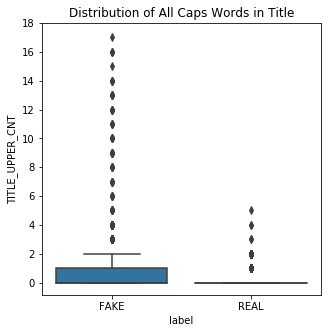

In [25]:
# Import the necessary visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import numpy as np
%matplotlib inline

# check visually with BoxPlot
plt.figure(figsize=(5,5))
sns.boxplot(df[y_col],df['TITLE_UPPER_CNT'])
plt.yticks(range(0,19,2))
plt.title('Distribution of All Caps Words in Title')
plt.show()

### Let's try zooming in on this upper half of the distribution and visualizing the Information with line graphs to get a more detailed view

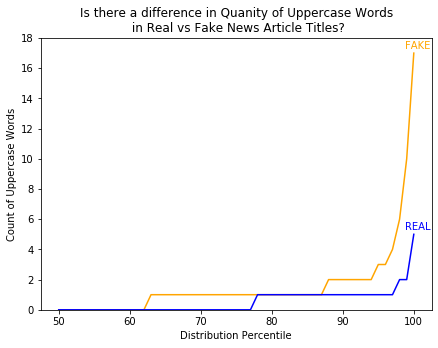

In [26]:
d_color = {'FAKE':'orange','REAL':'blue'}

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
#ax.yaxis.tick_right()

plt.xticks(range(0,t_distro['FAKE'].index.max()+1,10))
plt.ylim([0,t_distro['FAKE'].values.max()+1])
plt.yticks(range(0,20,2))
plt.title('Is there a difference in Quanity of Uppercase Words\n in Real vs Fake News Article Titles?')
plt.xlabel('Distribution Percentile')
plt.ylabel('Count of Uppercase Words')


plt.plot(t_distro['FAKE'].index.tolist()[50:],t_distro['FAKE'].values.tolist()[50:],color=d_color['FAKE'],label='FAKE')
plt.plot(t_distro['REAL'].index.tolist()[50:],t_distro['REAL'].values.tolist()[50:],color=d_color['REAL'],label='REAL')

plt.text(x=t_distro['FAKE'].index.max()-1.2, y =t_distro['FAKE'].values.max()+.3,s='FAKE',color=d_color['FAKE'])
plt.text(x=t_distro['REAL'].index.max()-1.2, y =t_distro['REAL'].values.max()+.3,s='REAL',color=d_color['REAL'])
#plt.legend(bbox_to_anchor=(1, 1),
#           bbox_transform=plt.gcf().transFigure)
plt.show()


### Looks promising to add this feature, but to validate this hypothesis check using a two-way Chi-Square test.
- Here we see that FAKE articles have a long tail, with up to 17 uppercase words in a single title, whereas the REAL artilces have up to a maximum of 5 in a single instance.  And only 5 REAL articles out of the 3100+ samples have more than 2 uppercase words.

In [122]:
tbl_contingency = pd.crosstab(df[y_col],df['TITLE_UPPER_CNT'])
tbl_contingency

TITLE_UPPER_CNT,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
label,,,,,,,,,,,,,,,,,,
FAKE,1985,785,213,69,31,12,6,9,6,11,7,5,7,6,6,1,4,1
REAL,2469,632,65,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0


### Given the extreme outliers in REAL articles with more than 2 uppercase words, let's refactor this feature as 0,1 2, or 2+ (encoded as 3) upper case words
- This will enable us to use the Chi-Squared test, which operates under the assumption that 80% of cells in the contingency table contain a value count of at least 5, with no cells having less a value count of less than 1.


- An added advantage is that when we get to the modeling phase, a simplified feature would be more generalizable by a model since it will only result in 4 levels for a model to consider as opposed to 18.

In [27]:
df['TITLE_UPPER_CNT_2'] = df['TITLE_UPPER_CNT'].apply(lambda x: x if x <=2 else 3)

In [28]:
tbl_contingency = pd.crosstab(df[y_col],df['TITLE_UPPER_CNT_2'])
tbl_contingency

TITLE_UPPER_CNT_2,0,1,2,3
label,,,,
FAKE,1985,785,213,181
REAL,2469,632,65,5


### The Chi-Squared test will help confirm our hypothesis, that the target variable is likely dependent on the engineered feature variable of Uppercase word count in the Title
- We will use a signifigance threshold of 5% (alpha) in our two-way test

In [29]:
# Set the alpha for significant to 5%.  It is important to set the significance level prior to testing
alpha = 0.05
# Perform a two-way chi-square test to determine if there is likely a relationship between the target variable 
# (FAKE vs REAL) and the count of upper case words in the Title
stat, p, dof, expected = chi2_contingency(tbl_contingency)

### Take a look at the expected output of the distrubtions 
- This visual check will ensure that enough cells (80%) have a value of at least 5 or more so that we know we can trust the test results

In [30]:
# Expected Distribution assuming two independent variables
pd.DataFrame(expected,index=df[y_col].unique())

,0,1,2,3
FAKE,2224.539227,707.717127,138.846409,92.897238
REAL,2229.460773,709.282873,139.153591,93.102762


### Check to see if there is a significant p-value  and at the associated Chi-Square test statistic 
- This will indicate how different our acrtual distributions are from the expected distributions 
- This shows an extremely large test statistic, indicating why the p-value was nearly 0.
- Based on these results it is likely that the target variable (FAKE vs REAL) is dependent on the independent variable of  that we should look at including this engineering feature in our model

In [31]:
sig = 'not significant' if p > alpha else 'significant'
print('A Chi-square statistic of {:.2f} with a p-value of {:.2f} indicates this result is likely {}.'.format(stat,p,sig))

A Chi-square statistic of 314.44 with a p-value of 0.00 indicates this result is likely significant.


### We can repeat the process for the TEXT column feature
- The quartile breakdown show with the pandas describe method coupled with the boxplot visualization indicates these distrubtions are somewhat similar, especially compare to the Title feature

In [32]:
df[['TEXT_UPPER_CNT',y_col]].groupby(y_col).describe()

TEXT_UPPER_CNT                                                  
               count       mean        std  min  25%  50%   75%    max
label                                                                 
FAKE          3164.0  12.999684  24.818997  0.0  3.0  7.0  15.0  697.0
REAL          3171.0  10.690634  13.385306  0.0  3.0  7.0  14.0  146.0

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


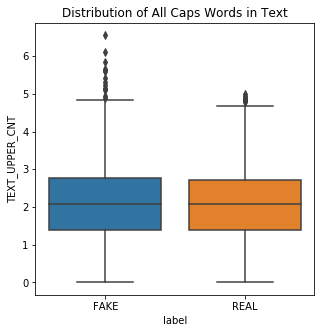

In [33]:
# check visually with BoxPlot
plt.figure(figsize=(5,5))
sns.boxplot(df[y_col],np.log1p(df['TEXT_UPPER_CNT']))
#plt.yticks(range(0,19,2))
plt.title('Distribution of All Caps Words in Text')
plt.show()

### For completeness, let's confirm with the two-way Chi-Squared test
- Looking at the contingency table, no good cutoff number emerges since both FAKE and REAL articles have such large numbers

In [34]:
tbl_contingency = pd.crosstab(df[y_col],df['TEXT_UPPER_CNT'])
tbl_contingency

TEXT_UPPER_CNT,0,1,2,3,4,5,6,7,8,9,...,166,171,184,200,223,272,282,348,446,697
label,,,,,,,,,,,,,,,,,,,,,
FAKE,266,235,234,211,215,188,173,145,135,119,...,1,1,1,1,1,2,1,1,1,1
REAL,276,177,186,183,200,220,196,175,184,132,...,0,0,0,0,0,0,0,0,0,0


### Maybe a closer look at the distributions will help
# NB: CONVERT THIS TO A HISTO OR BARPLOT

In [35]:
word_cnt = 5
t_distro = {}
for g,f in df.groupby(y_col):
    temp_cat = f.loc[f[y_col] == g,'TEXT_UPPER_CNT'].tolist()
    t_distro[g] = pd.Series([int(np.percentile(temp_cat,p)) for p in range(101)])
    for cnt in range(word_cnt):    
        print('{} News TEXT: {}% Contain at least {} Upper Case Word.'.format(g,100-t_distro[g].loc[t_distro[g] > cnt].idxmin(),cnt+1))
    print()

FAKE News TEXT: 91% Contain at least 1 Upper Case Word.
FAKE News TEXT: 84% Contain at least 2 Upper Case Word.
FAKE News TEXT: 76% Contain at least 3 Upper Case Word.
FAKE News TEXT: 70% Contain at least 4 Upper Case Word.
FAKE News TEXT: 63% Contain at least 5 Upper Case Word.

REAL News TEXT: 91% Contain at least 1 Upper Case Word.
REAL News TEXT: 85% Contain at least 2 Upper Case Word.
REAL News TEXT: 79% Contain at least 3 Upper Case Word.
REAL News TEXT: 74% Contain at least 4 Upper Case Word.
REAL News TEXT: 67% Contain at least 5 Upper Case Word.



#### A graph of these respective distributions shows they diverge at the tail ends
- Zooming in on the upper 10% of the distribution, shows divergence at the 99th percentile.
- Given this and the raw numbers from the t_distro cell above, I will set the upper end for both to 10 to balance feature value and model simplicity

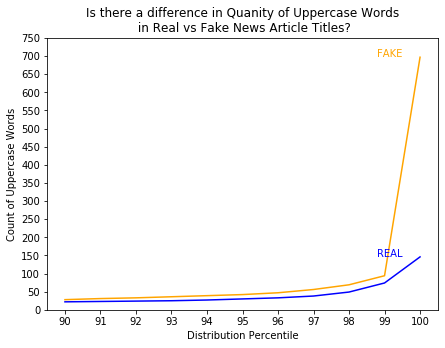

In [36]:
# MAKE THIS INTO A FUNCTION
d_color = {'FAKE':'orange','REAL':'blue'}

zoom_lower = 90
zoom_upper = None
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
#ax.yaxis.tick_right()

plt.xticks(range(0,t_distro['FAKE'].index.max()+1,10))
plt.ylim([0,t_distro['FAKE'].values.max()+1])
plt.yticks(range(0,751,50))
plt.xticks(range(90,101,1))
plt.title('Is there a difference in Quanity of Uppercase Words\n in Real vs Fake News Article Titles?')
plt.xlabel('Distribution Percentile')
plt.ylabel('Count of Uppercase Words')


plt.plot(t_distro['FAKE'].index.tolist()[zoom_lower:zoom_upper],t_distro['FAKE'].values.tolist()[zoom_lower:zoom_upper],color=d_color['FAKE'],label='FAKE')
plt.plot(t_distro['REAL'].index.tolist()[zoom_lower:zoom_upper],t_distro['REAL'].values.tolist()[zoom_lower:zoom_upper],color=d_color['REAL'],label='REAL')

plt.text(x=t_distro['FAKE'].index.max()-1.2, y =t_distro['FAKE'].values.max()+.3,s='FAKE',color=d_color['FAKE'])
plt.text(x=t_distro['REAL'].index.max()-1.2, y =t_distro['REAL'].values.max()+.3,s='REAL',color=d_color['REAL'])
#plt.legend(bbox_to_anchor=(1, 1),
#           bbox_transform=plt.gcf().transFigure)
plt.show()

### Limiting the value count to 10 is a compromise between extracting value from the feature while at the same time minimizing complexity of the model that will likely be quite sparce once the text is converted to a document term matrix of tfidf scores.
- An instance of the bias-variance trade-off.  Including the entire range of known values would increase the variability, but would increase model complexity and lead to overfitting of any model we build later.

In [37]:
df['TEXT_UPPER_CNT_2'] = df['TEXT_UPPER_CNT'].apply(lambda x: x if x <=9 else 10)

In [38]:
tbl_contingency = pd.crosstab(df[y_col],df['TEXT_UPPER_CNT_2'])
tbl_contingency

TEXT_UPPER_CNT_2,0,1,2,3,4,5,6,7,8,9,10
label,,,,,,,,,,,
FAKE,266,235,234,211,215,188,173,145,135,119,1243
REAL,276,177,186,183,200,220,196,175,184,132,1242


### A chi-square test shows that the target feature might be dependent on the number of upperacase words in the text.  
- This is not what I hypotheszied, however given this result, I will hold onto the variable for potential use in a model
- It is worth noting that 

In [40]:
# Set the alpha for significant to 5%.  It is important to set the significance level prior to testing
alpha = 0.05
# Perform a two-way chi-square test to determine if there is likely a relationship between the target variable 
# (FAKE vs REAL) and the count of upper case words in the Title
stat, p, dof, expected = chi2_contingency(tbl_contingency)

sig = 'not significant' if p > alpha else 'significant'
print('A Chi-square statistic of {:.2f} with a p-value of {:.2f} indicates this result is likely {}.'.format(stat,p,sig))

A Chi-square statistic of 31.32 with a p-value of 0.00 indicates this result is likely significant.


## Once we get to the modeling phase we can check to see if this feature does in fact help us achieve a better model